In [1]:
!pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.29-py3-none-any.whl size=8613 sha256=7c523430311a3832bc9d75af6e86216247d72c8d913a7bb4d6e27c23b53fbec1
  Stored in directory: /root/.cache/pip/wheels/9e/2e/42/17cb826d143226e4d081aa33d3a9b9a90f234dfcf409824b87
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.26-py3-none-any.whl size=7612 sha256=2e3db87e3a2c383319cc955f325975044707b0ab38084f493a7678ff7a79b6d8
  Stored in directory: /root/.cache/pip/wheels/15/65/34/2e11a0da3cf6f112da5c402e01c454be619ff85a0fb38b3018
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4585 sha256=114a8a730963bfeba995983edd0eb3ec0905e0027d1e396b1ceadd6d494c0202
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [5]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/4/')


Mounted at /content/gdrive


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 15 21:39:26 2020

@author: isswan
"""

import pandas as pd
import numpy as np

from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D,Reshape, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate
from keras.models import load_model

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.externals import joblib

import matplotlib.pyplot as plt
from plot_keras_history import plot_history



/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [17]:
import keras
print(keras.__version__)

2.6.0


In [7]:
#Data Preparation
import pandas as pd
news=pd.read_table('r8-full-data.txt',header=None,names = ["Class", "Text"])
news.head()



,Class,Text
0,trade,asian exporters fear damage from u s japan rif...
1,grain,china daily says vermin eat pct grain stocks a...
2,ship,australian foreign ship ban ends but nsw ports...
3,acq,sumitomo bank aims at quick recovery from merg...
4,earn,amatil proposes two for five bonus share issue...


In [10]:
a = news.groupby("Class")
a.head()
a.describe()

Text                                                               
         count unique                                                top freq
Class                                                                        
acq       2292   2285  nippon life seeking tie with u s securities ho...    2
crude      374    366  reagan says u s needs to lessen oil imports pr...    2
earn      3923   3915  kasler corp kasl st qtr jan net shr profit thr...    2
grain       51     51  dutch grain levy test case to start in april a...    1
interest   271    249  canada day t bills average pct making bank rat...    3
money-fx   293    280  sumita says bank will intervene if necessary b...    3
ship       144    141  agency reports ships waiting at panama canal t...    3
trade      326    312  japan u s will be at odds while trade lopsided...    2

<Figure size 432x288 with 0 Axes>

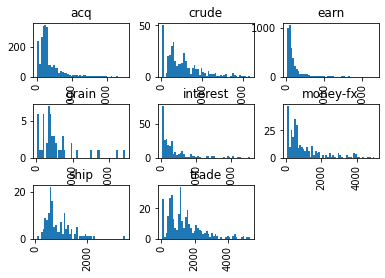

<Figure size 432x288 with 0 Axes>

In [11]:
y=news['Class']
X=news['Text']

##check the length to determine the document length for DNN

length=news['Text'].apply(len)
news=news.assign(Length=length)

#Plot the distribution of the document length for each category
import matplotlib.pyplot as plt
news.hist(column='Length',by='Class',bins=50)

plt.figure()

In [12]:
length
news

,Class,Text,Length
0,trade,asian exporters fear damage from u s japan rif...,4279
1,grain,china daily says vermin eat pct grain stocks a...,593
2,ship,australian foreign ship ban ends but nsw ports...,1145
3,acq,sumitomo bank aims at quick recovery from merg...,3971
4,earn,amatil proposes two for five bonus share issue...,578
...,...,...,...
7669,earn,kelly oil and gas partners kly year dec shr ct...,93
7670,money-fx,japan seeks to strengthen paris currency accor...,2051
7671,earn,tcw convertible securities cvt sets dividend t...,335
7672,money-fx,south korean won fixed at month high the bank ...,268


In [13]:
#Data Preprocessing 

# Split train & test
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X_train) # longest text in train set
print('vocabubary size:',vocab_size)
print('max length text:',maxlen)

#Padding the sentences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#embedding dimension should align with the GLOVE
embedding_dim = 100
vocab_size = len(word_index) + 1

GLOVE_6B_100D_PATH ="glove.6B.100d.txt"
encoding="utf-8"
with open(GLOVE_6B_100D_PATH, "rb") as lines:
    embeddings_index = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

# Prepare embedding matrix from pre-trained model
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size) # 84% of tokens have a embedding vector from glove, this is good already, the rest will just be all zeros, glove has 6 bil tokens  

vocabubary size: 19998
max length text: 964
0.848034803480348


In [14]:
#create class weight dict for unbanlanced dataset
#If 'balanced', class weights will be given by n_samples / (n_classes * np.bincount(y)
# classes with lesser samples, will have highe weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_d = dict(enumerate(class_weights))

##onehot encoding for y
def categoricalList2Onehot(listOfClasses):
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(listOfClasses)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

y_train_onehot = categoricalList2Onehot(y_train)
y_train_onehot.shape
y_test_onehot = categoricalList2Onehot(y_test)
y_test_onehot.shape

(2303, 8)

In [21]:
class_weights_d

{0: 0.4159696406443618,
 1: 2.5145131086142323,
 2: 0.2459249084249084,
 3: 16.375,
 4: 3.6487771739130435,
 5: 3.137266355140187,
 6: 7.142287234042553,
 7: 2.9575991189427313}

In [38]:
# Shallow CNN
# Todo: replace the "???" with correct piece of code
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))  # Freeze the embedding layer since we dont train it
model.add(Conv1D(512, 3, activation='relu')) # 3 - trigram, 512 kernels
model.add(GlobalMaxPooling1D())
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 964, 100)          1999800   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 962, 512)          154112    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 4104      
Total params: 2,158,016
Trainable params: 158,216
Non-trainable params: 1,999,800
_________________________________________________________________


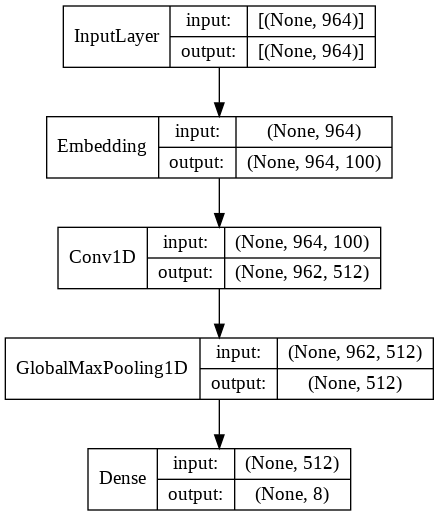

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

Epoch 1/25
84/84 [==============================] - 6s 66ms/step - loss: 0.9655 - accuracy: 0.7725 - val_loss: 0.3128 - val_accuracy: 0.9079
Epoch 2/25
84/84 [==============================] - 5s 62ms/step - loss: 0.1998 - accuracy: 0.9391 - val_loss: 0.2147 - val_accuracy: 0.9362
Epoch 3/25
84/84 [==============================] - 5s 62ms/step - loss: 0.1074 - accuracy: 0.9629 - val_loss: 0.1723 - val_accuracy: 0.9401
Epoch 4/25
84/84 [==============================] - 5s 63ms/step - loss: 0.0699 - accuracy: 0.9734 - val_loss: 0.1570 - val_accuracy: 0.9444
Epoch 5/25
84/84 [==============================] - 5s 62ms/step - loss: 0.0544 - accuracy: 0.9806 - val_loss: 0.1515 - val_accuracy: 0.9475
Epoch 6/25
84/84 [==============================] - 5s 63ms/step - loss: 0.0393 - accuracy: 0.9849 - val_loss: 0.1392 - val_accuracy: 0.9505
Epoch 7/25
84/84 [==============================] - 5s 63ms/step - loss: 0.0363 - accuracy: 0.9881 - val_loss: 0.1221 - val_accuracy: 0.9579
Epoch 8/25
84

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff79da05610>,
       dtype=object))

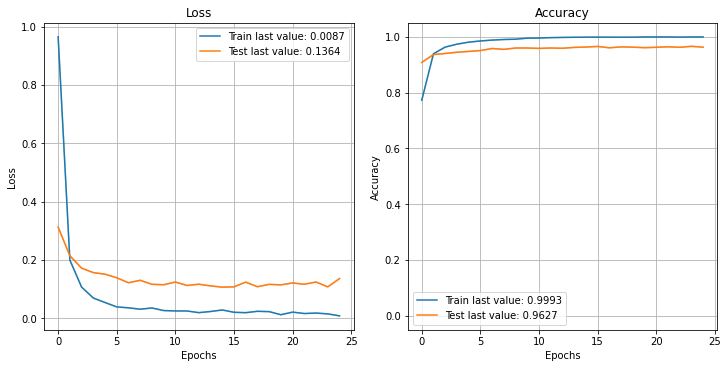

In [39]:
#train the model

hist = model.fit(X_train, y_train_onehot,
                    class_weight = class_weights_d,
                    epochs=25, 
                    verbose=True,
                    validation_data=(X_test, y_test_onehot),
                    batch_size=64).history

loss, accuracy = model.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

Experiment using 100 epochs, seems the model get alightly overfitted   
10-30 epochs seems to be good enough

In [40]:
# Excersice : Modify Shallow CNN with dropout Layer
#To do: add Dropout layer within the model defination and correct the ???

model_dp = Sequential()
model_dp.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False)) 
model_dp.add(Conv1D(512, 3, activation='relu'))
model_dp.add(Dropout(0.3))
model_dp.add(GlobalMaxPooling1D())
#model_dp.add(Dense(64, activation=???))
#dropout layer
model_dp.add(Dense(8, activation='softmax'))
model_dp.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_dp.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 964, 100)          1999800   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 962, 512)          154112    
_________________________________________________________________
dropout_7 (Dropout)          (None, 962, 512)          0         
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 4104      
Total params: 2,158,016
Trainable params: 158,216
Non-trainable params: 1,999,800
_________________________________________________________________


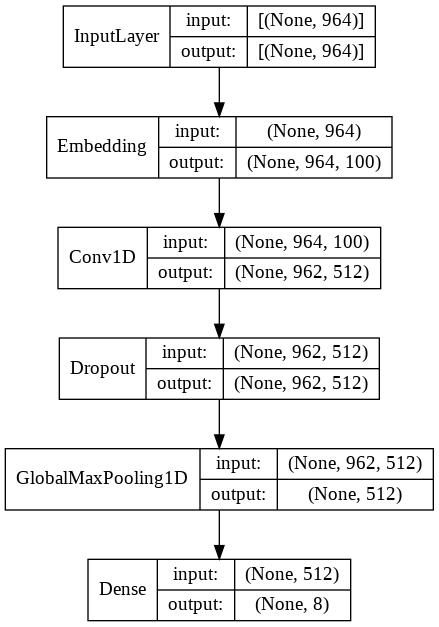

In [27]:
plot_model(model_dp, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

Epoch 1/25
84/84 [==============================] - 7s 76ms/step - loss: 0.9464 - accuracy: 0.7550 - val_loss: 0.3959 - val_accuracy: 0.9210
Epoch 2/25
84/84 [==============================] - 6s 74ms/step - loss: 0.2014 - accuracy: 0.9339 - val_loss: 0.2809 - val_accuracy: 0.9240
Epoch 3/25
84/84 [==============================] - 6s 74ms/step - loss: 0.1116 - accuracy: 0.9579 - val_loss: 0.2113 - val_accuracy: 0.9444
Epoch 4/25
84/84 [==============================] - 6s 73ms/step - loss: 0.0734 - accuracy: 0.9711 - val_loss: 0.1697 - val_accuracy: 0.9509
Epoch 5/25
84/84 [==============================] - 6s 73ms/step - loss: 0.0677 - accuracy: 0.9762 - val_loss: 0.1589 - val_accuracy: 0.9509
Epoch 6/25
84/84 [==============================] - 6s 74ms/step - loss: 0.0446 - accuracy: 0.9827 - val_loss: 0.1442 - val_accuracy: 0.9535
Epoch 7/25
84/84 [==============================] - 6s 73ms/step - loss: 0.0436 - accuracy: 0.9853 - val_loss: 0.1470 - val_accuracy: 0.9531
Epoch 8/25
84

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7a7b4b490>,
       dtype=object))

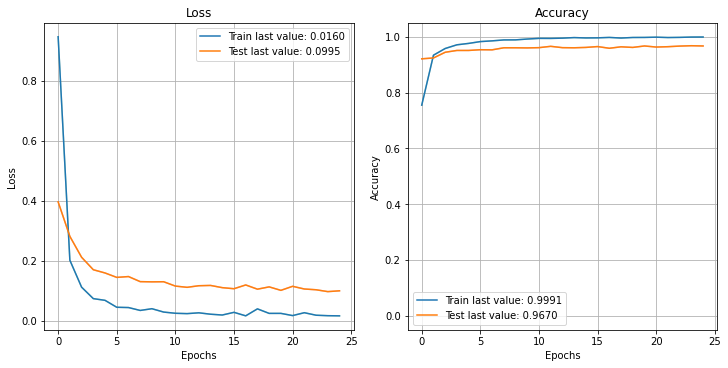

In [41]:
#train the model

hist_dp = model_dp.fit(X_train, y_train_onehot,
                    class_weight = class_weights_d,
                    epochs=25,
                    verbose=True,
                    validation_data=(X_test, y_test_onehot),
                    batch_size=64).history

loss, accuracy = model_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_dp)

In [42]:
##Deep CNN 
# define the model
from keras.layers.merge import concatenate
from keras import Model

def define_model(length, vocab_size,embedding_dim):
	# channel 1
	inputs1 = Input(shape=(length,))
	embedding1 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs1)
	conv1 = Conv1D(filters=128, kernel_size=2, activation='relu')(embedding1)
	drop1 = Dropout(0.5)(conv1)
	pool1 = MaxPooling1D(pool_size=2)(drop1)
	flat1 = Flatten()(pool1)
	# channel 2
	inputs2 = Input(shape=(length,))
	embedding2 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs2)
	conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding2)
	drop2 = Dropout(0.5)(conv2)
	pool2 = MaxPooling1D(pool_size=2)(drop2)
	flat2 = Flatten()(pool2)
	# channel 3
	inputs3 = Input(shape=(length,))
	embedding3 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs3)
	conv3 = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding3)
	drop3 = Dropout(0.5)(conv3)
	pool3 = MaxPooling1D(pool_size=2)(drop3)
	flat3 = Flatten()(pool3)
	# merge
	merged = concatenate([flat1, flat2, flat3])
	# interpretation
	dense1 = Dense(64, activation='relu')(merged)
	outputs = Dense(8, activation='softmax')(dense1)
	model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# summarize
	print(model.summary())
	return model

model_deep = define_model(maxlen,vocab_size,embedding_dim)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 964)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 964)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 964)]        0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 964, 100)     1999800     input_7[0][0]                    
____________________________________________________________________________________________

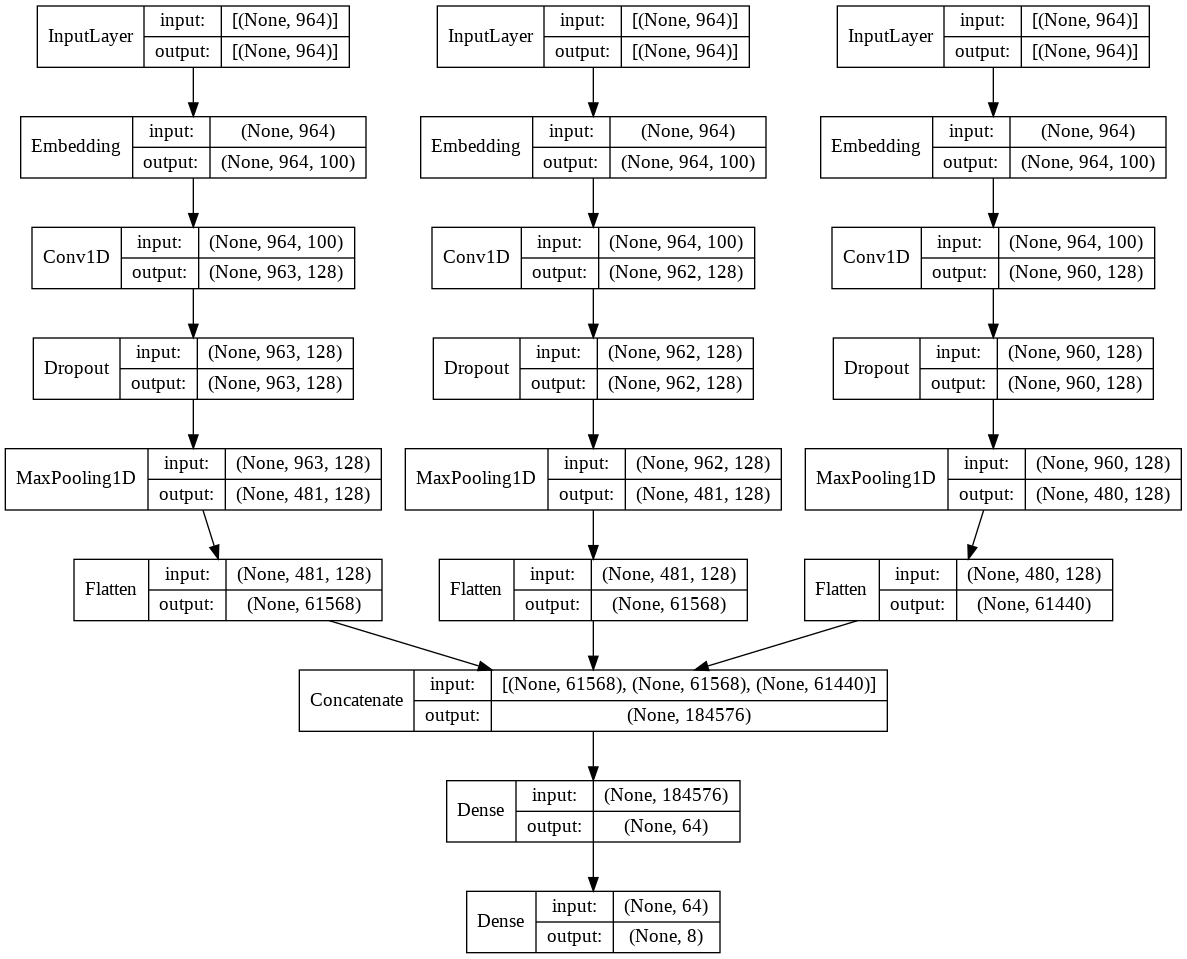

In [45]:
plot_model(model_deep, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

Epoch 1/25
84/84 [==============================] - 7s 74ms/step - loss: 1.8441 - accuracy: 0.7129 - val_loss: 0.4914 - val_accuracy: 0.8658
Epoch 2/25
84/84 [==============================] - 6s 70ms/step - loss: 0.3159 - accuracy: 0.9199 - val_loss: 0.2492 - val_accuracy: 0.9223
Epoch 3/25
84/84 [==============================] - 6s 70ms/step - loss: 0.0790 - accuracy: 0.9704 - val_loss: 0.2186 - val_accuracy: 0.9331
Epoch 4/25
84/84 [==============================] - 6s 70ms/step - loss: 0.0361 - accuracy: 0.9883 - val_loss: 0.2404 - val_accuracy: 0.9314
Epoch 5/25
84/84 [==============================] - 6s 70ms/step - loss: 0.0237 - accuracy: 0.9929 - val_loss: 0.1844 - val_accuracy: 0.9475
Epoch 6/25
84/84 [==============================] - 6s 71ms/step - loss: 0.0258 - accuracy: 0.9927 - val_loss: 0.2187 - val_accuracy: 0.9388
Epoch 7/25
84/84 [==============================] - 6s 71ms/step - loss: 0.0177 - accuracy: 0.9961 - val_loss: 0.2109 - val_accuracy: 0.9409
Epoch 8/25
84

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff840093790>,
       dtype=object))

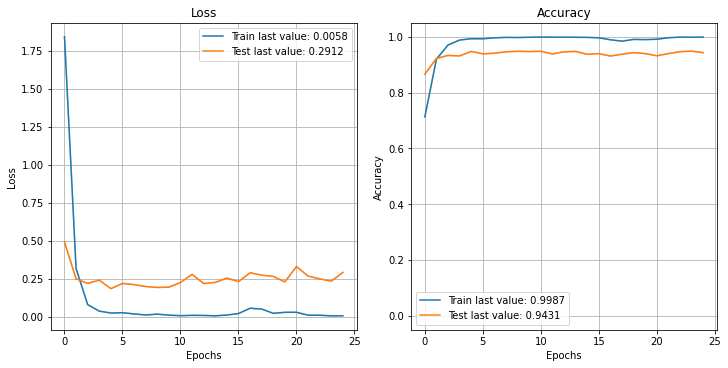

In [43]:
#train the model

hist_deep = model_deep.fit([X_train,X_train,X_train], y_train_onehot,
                    class_weight = class_weights_d,
                    epochs=25,
                    verbose=True,
                    validation_data=([X_test,X_test,X_test], y_test_onehot),
                    batch_size=64).history

loss, accuracy = model_deep.evaluate([X_train,X_train,X_train], y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_deep.evaluate([X_test,X_test,X_test], y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_deep)

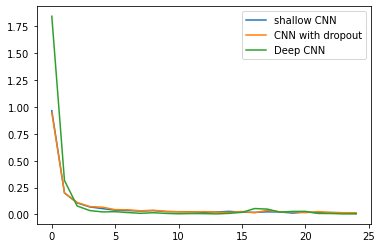

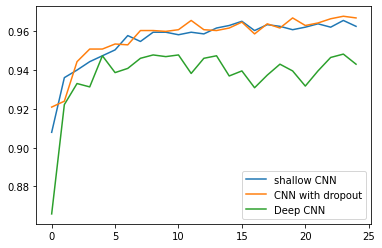

In [44]:
#Compare all the models

plt.plot(hist['loss'], label='shallow CNN')
plt.plot(hist_dp['loss'], label='CNN with dropout')
plt.plot(hist_deep['loss'], label='Deep CNN')
plt.legend(loc='upper right')
plt.show()

plt.plot(hist['val_accuracy'], label='shallow CNN')
plt.plot(hist_dp['val_accuracy'], label='CNN with dropout')
plt.plot(hist_deep['val_accuracy'], label='Deep CNN')
plt.legend(loc='lower right')
plt.show()


Deep CNN does not seem to perform so well as compared to shallow CNN's, it is overkill to simple problem   
CNN with dropout might be helpful, but it does not seem significant